In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset,DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/BERT/labeled_data.csv")
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


<Axes: xlabel='class', ylabel='count'>

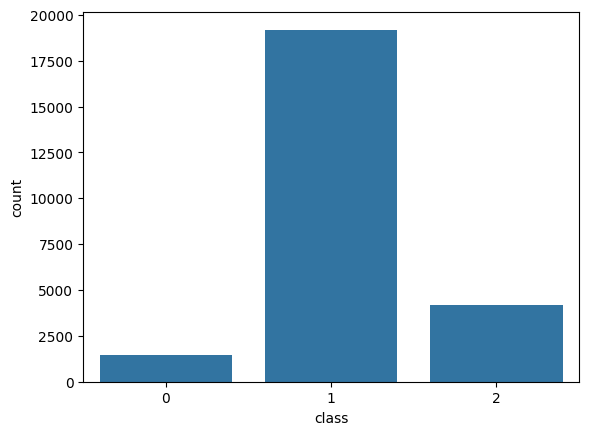

In [ ]:
sns.countplot(x='class', data=df)

In [ ]:
df['tweet_cleaned'] = df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [ ]:
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [ ]:
train_test_valid = dataset.train_test_split()
test_valid = train_test_valid['test'].train_test_split()
train_test_valid_dataset = DatasetDict({
    'train' : train_test_valid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

In [ ]:
cols_to_remove = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither']
dataset = train_test_valid_dataset.remove_columns(cols_to_remove)
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(f"Vocab Size: {tokenizer.vocab_size}")
print(f"Max Model Length: {tokenizer.model_max_length}")
print(f"Model Inputs: {tokenizer.model_input_names}")

Vocab Size: 28996
Max Model Length: 512
Model Inputs: ['input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
def tokenize_dataset_function(train_dataset):
    return tokenizer(train_dataset["tweet_cleaned"],padding = "max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_dataset_function,batched=True)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [ ]:
train_set = train_dataset.remove_columns(['tweet', 'tweet_cleaned']).with_format('tensorflow')
test_set = test_dataset.remove_columns(['tweet', 'tweet_cleaned']).with_format('tensorflow')
eval_set = eval_dataset.remove_columns(['tweet', 'tweet_cleaned']).with_format('tensorflow')
print(train_set,eval_set,test_set)

Dataset({
    features: ['class', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
}) Dataset({
    features: ['class', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4647
}) Dataset({
    features: ['class', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1549
})


In [ ]:
model_input_names = tokenizer.model_input_names
train_features = {x: train_set[x] for x in model_input_names}
train_set_final = tf.data.Dataset.from_tensor_slices((train_features,train_set['class']))
train_set_final = train_set_final.shuffle(len(train_set)).batch(8)

eval_features = {x: eval_set[x] for x in model_input_names}
eval_set_final = tf.data.Dataset.from_tensor_slices((eval_features,eval_set['class']))
eval_set_final = eval_set_final.shuffle(len(eval_set)).batch(8)

test_features = {x: test_set[x] for x in model_input_names}
test_set_final = tf.data.Dataset.from_tensor_slices((test_features,test_set['class']))
test_set_final = test_set_final.shuffle(len(test_set)).batch(8)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history = model.fit(train_set_final,validation_data = eval_set_final, epochs = 3)


Epoch 1/3
2324/2324 [==============================] - 2329s 981ms/step - loss: 0.3170 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.3004 - val_sparse_categorical_accuracy: 0.8989
Epoch 2/3
2324/2324 [==============================] - 2290s 985ms/step - loss: 0.2796 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.2925 - val_sparse_categorical_accuracy: 0.8894
Epoch 3/3
2324/2324 [==============================] - 2276s 979ms/step - loss: 0.2710 - sparse_categorical_accuracy: 0.9063 - val_loss: 0.3212 - val_sparse_categorical_accuracy: 0.8823


In [ ]:
test_loss, test_acc = model.evaluate(test_set_final,verbose=2)
print('\nTest accuracy:', test_acc)

194/194 - 64s - loss: 0.3065 - sparse_categorical_accuracy: 0.8864 - 64s/epoch - 329ms/step

Test accuracy: 0.886378288269043


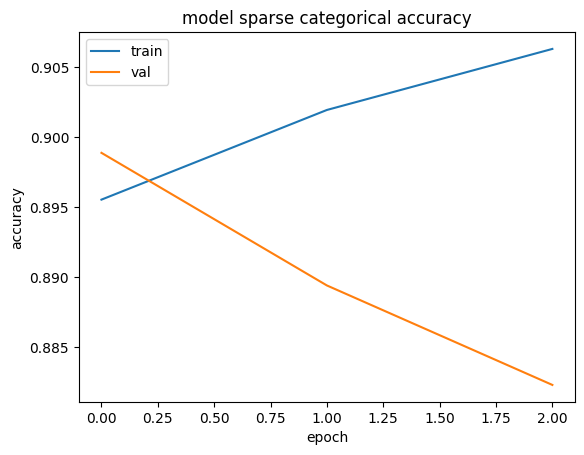

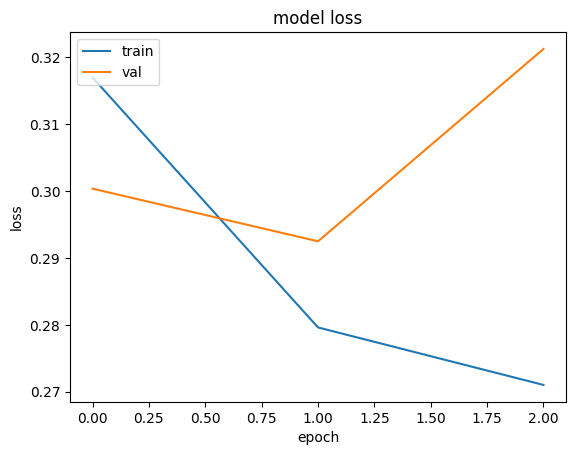

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save_pretrained("/content/drive/MyDrive/BERT/fine_tuned_bert")
tokenizer.save_pretrained("/content/drive/MyDrive/BERT/fine_tuned_bert")


('/content/drive/MyDrive/BERT/fine_tuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/BERT/fine_tuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/BERT/fine_tuned_bert/vocab.txt',
 '/content/drive/MyDrive/BERT/fine_tuned_bert/added_tokens.json',
 '/content/drive/MyDrive/BERT/fine_tuned_bert/tokenizer.json')

In [5]:
model = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/BERT/fine_tuned_bert")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/BERT/fine_tuned_bert")

Some layers from the model checkpoint at /content/drive/MyDrive/BERT/fine_tuned_bert were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/BERT/fine_tuned_bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [6]:
class_dict = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

def predict_class(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)
    logits = model(inputs)['logits']
    pred = int(np.argmax(logits, axis=1))
    return class_dict[pred]

In [19]:
label = predict_class("")
print(label)

Neither


<ipython-input-6-54f497a637a2>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(np.argmax(logits, axis=1))
